# 🚗 CAR DEMAND PREDICTION & INTERPRETATION
**PHẦN 2: XÂY DỰNG MÔ HÌNH & GIẢI THÍCH ĐẶC TRƯNG (XAI)**  
*(Thuộc dự án: CAR PURCHASE DECISION ANALYSIS - XAI)*

---

### 👤 AUTHOR INFO
* **Tác giả:** Bùi Tiến Phát (Higo)
* **Email:** higo.individual@gmail.com
* **Project Type:** Machine Learning / Predictive Analytics
* **Kỹ thuật:** Linear Regression, Random Forest Regressor, Hyperparameter Tuning, SHAP.

---

### 📝 MODULE HIGHLIGHTS (TÍNH NĂNG NỔI BẬT):

* **Data Leakage Control (Kiểm soát rò rỉ dữ liệu):** Loại bỏ các biến thành phần (`Male`, `Female`, `Unknown`) và biến định danh (`Model`) để triệt tiêu sự phụ thuộc tuyến tính trực tiếp, buộc mô hình phải trích xuất đặc trưng từ thông số kỹ thuật và giá trị thương mại.
* **Algorithm Benchmarking (So sánh thuật toán):** Thiết lập thực nghiệm đối chứng giữa **Linear Regression** (Baseline) và **Random Forest Regressor** để định lượng hiệu quả của phương pháp phi tuyến trong việc giải thích phương sai dữ liệu nhu cầu thị trường.
* **Stochastic Optimization (Tối ưu hóa tham số):** Ứng dụng `RandomizedSearchCV` để tinh chỉnh không gian tham số (Hyperparameter Space), tối ưu hóa chỉ số $R^2$ và RMSE, đồng thời kiểm soát hiện tượng quá khớp (Overfitting).
* **Interpretability Analysis (Giải thích mô hình):** Kết hợp `Permutation Importance` để xác định trọng số đặc trưng toàn cục và `SHAP Values` để định lượng mức độ đóng góp cũng như chiều hướng tác động của từng biến số đến biến mục tiêu (`Total`).
* **Artifact Serialization (Lưu trữ mô hình):** Đóng gói mô hình tối ưu và cấu trúc vector đầu vào dưới định dạng `.joblib`, đảm bảo tính toàn vẹn của đặc trưng (Features) khi tích hợp vào môi trường triển khai thực tế.

**BƯỚC 1: KHỞI TẠO & KIỂM TRA DỮ LIỆU**  
Mục đích: Thiết lập môi trường và kiểm tra độ sạch của dữ liệu trước khi huấn luyện.

In [1]:
# --- #1: KHAI BÁO THƯ VIỆN & CẤU HÌNH ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os

# Thư viện Machine Learning chuyên dụng
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Cấu hình hiển thị
pd.set_option('display.max_columns', None) # Hiển thị tất cả các cột
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

print("✅ Hệ thống đã sẵn sàng!")

✅ Hệ thống đã sẵn sàng!


In [2]:
# --- #2: TẢI DỮ LIỆU TỪ GITHUB ---
DATA_URL = "https://raw.githubusercontent.com/higo-ai/Car-Purchase-Decision-Analysis-XAI/refs/heads/main/data/processed_carbuyers.csv"

print("--> ⏳ Đang tải dữ liệu sạch...")
try:
    df = pd.read_csv(DATA_URL)
    print(f"✅ Tải thành công! Kích thước: {df.shape}")
    display(df.head(8))
except Exception as e:
    print(f"❌ Lỗi: {e}")

--> ⏳ Đang tải dữ liệu sạch...
✅ Tải thành công! Kích thước: (6092, 11)


,Manufacturer,Model,Price,Transmission,Power,Engine CC,Fuel,Male,Female,Unknown,Total
0,Ford,Focus,30.619322,5.966102,94.033898,1497.169492,petrol,814172.0,422731.0,56487.0,1293390.0
1,Ford,Fiesta,18.532143,5.714286,68.571429,1166.142857,petrol,554879.0,631666.0,54057.0,1240602.0
2,Volkswagen,Golf,31.242154,6.164835,89.461538,1537.406593,petrol,483216.0,310604.0,47563.0,841383.0
3,Renault,Clio,22.100000,5.615385,75.576923,1219.653846,petrol,241287.0,312556.0,28004.0,581847.0
4,BMW,320i,47.848370,6.444444,126.111111,1995.777778,petrol,408016.0,115843.0,29125.0,552984.0
5,Volkswagen,Polo,18.192500,5.074074,60.962963,1408.055556,petrol,216333.0,299110.0,31701.0,547144.0
6,Peugeot,206,20.033750,4.833333,71.333333,1631.500000,petrol,178698.0,250614.0,26135.0,455447.0
7,Ford,Mondeo,39.973750,1.750000,130.250000,1998.500000,petrol,357452.0,69603.0,16550.0,443605.0


--> 🛠️ Kiểu dữ liệu hiện tại:
Manufacturer     object
Model            object
Price           float64
Transmission    float64
Power           float64
Engine CC       float64
Fuel             object
Male            float64
Female          float64
Unknown         float64
Total           float64
dtype: object

--> 📊 Biểu đồ tương quan (Heatmap):


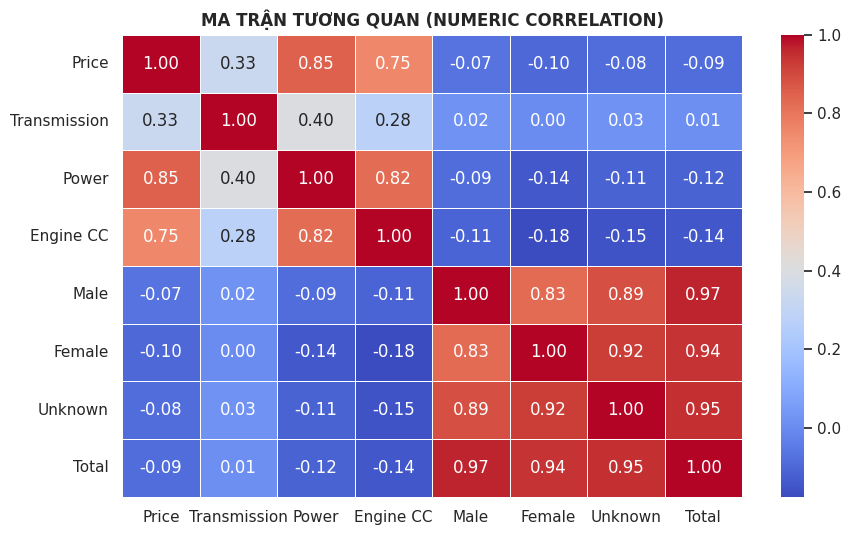

In [3]:
# --- #3: KIỂM TRA DTYPES & TƯƠNG QUAN TUYẾN TÍNH ---
# 1. Kiểm tra kiểu dữ liệu
print("--> 🛠️ Kiểu dữ liệu hiện tại:")
print(df.dtypes)

# 2. Vẽ Heatmap
print("\n--> 📊 Biểu đồ tương quan (Heatmap):")
num_cols = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.heatmap(num_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('MA TRẬN TƯƠNG QUAN (NUMERIC CORRELATION)', fontweight='bold')
plt.show()

**BƯỚC 2: CHUẨN BỊ DỮ LIỆU (PRE-PROCESSING)**  
Mục đích: Loại bỏ các cột gây nhiễu (Data Leakage) và mã hóa dữ liệu sang dạng số.

In [4]:
# --- #4: CHUẨN BỊ X, Y VÀ CHIA TẬP TRAIN/TEST ---

# 1. Loại bỏ các cột gây nhiễu và cột chữ không cần thiết
# Bỏ Male, Female, Unknown vì chúng là thành phần của Total (Tránh Data Leakage)
drop_cols = ['Total', 'Male', 'Female', 'Unknown', 'Model']
X_raw = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['Total']

# 2. One-Hot Encoding (Mã hóa các biến phân loại như Manufacturer, Fuel)
X = pd.get_dummies(X_raw, drop_first=True)

# 3. Chia tập dữ liệu (80% Học - 20% Kiểm thử)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"--> ✅ Đã tách dữ liệu huấn luyện:")
print(f"    - Đặc trưng đầu vào (Features): {X_train.shape[1]} cột")
print(f"    - Tập huấn luyện (Train Set):  {X_train.shape[0]} dòng")
print(f"    - Tập kiểm thử (Test Set):    {X_test.shape[0]} dòng")

--> ✅ Đã tách dữ liệu huấn luyện:
    - Đặc trưng đầu vào (Features): 57 cột
    - Tập huấn luyện (Train Set):  4873 dòng
    - Tập kiểm thử (Test Set):    1219 dòng


**BƯỚC 3: THỰC NGHIỆM MÔ HÌNH (EXPERIMENTS)**  
Mục đích: So sánh hiệu quả giữa Linear Regression và Random Forest.

In [5]:
# --- #5: THỬ NGHIỆM 1 - LINEAR REGRESSION ---
print("Running Linear Regression...")

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Đánh giá hiệu năng
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("-" * 30)
print(f"📉 KẾT QUẢ LINEAR REGRESSION:")
print(f"   ➤ R² Score: {r2_lr:.4f}")
print(f"   ➤ RMSE:     {rmse_lr:,.2f}")

Running Linear Regression...
------------------------------
📉 KẾT QUẢ LINEAR REGRESSION:
   ➤ R² Score: 0.1948
   ➤ RMSE:     128,436.44


In [6]:
# --- #6: THỬ NGHIỆM 2 - RANDOM FOREST (BASE) ---
print("Running Random Forest (Base Model)...")

rfr = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)
y_pred_rf = rfr.predict(X_test)

# Đánh giá hiệu năng
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("-" * 30)
print(f"🌲 KẾT QUẢ RANDOM FOREST (BASE):")
print(f"   ➤ R² Score: {r2_rf:.4f}")
print(f"   ➤ RMSE:     {rmse_rf:,.2f}")

Running Random Forest (Base Model)...
------------------------------
🌲 KẾT QUẢ RANDOM FOREST (BASE):
   ➤ R² Score: 0.7474
   ➤ RMSE:     71,935.21


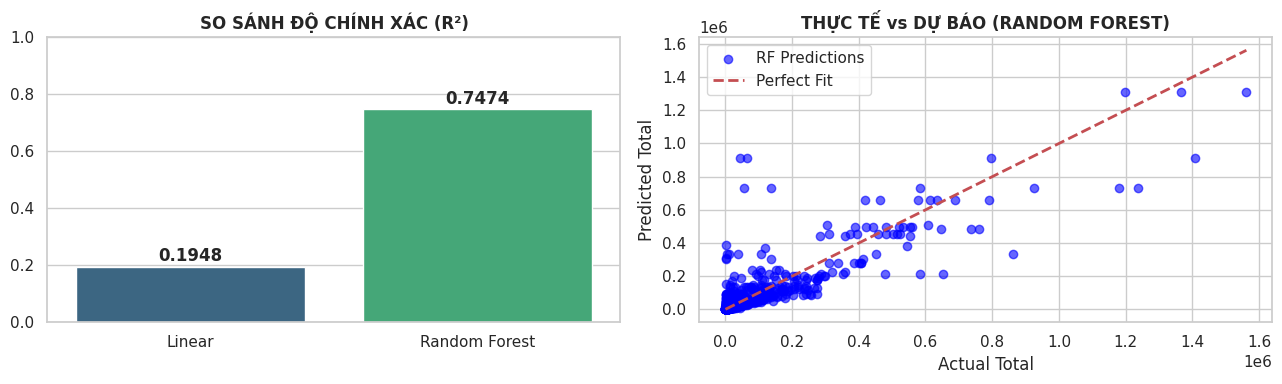

In [7]:
# --- #7: TRỰC QUAN HÓA SO SÁNH HIỆU NĂNG ---
models = ['Linear', 'Random Forest']
r2_scores = [r2_lr, r2_rf]

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# Biểu đồ 1: So sánh R2
sns.barplot(x=models, y=r2_scores, palette='viridis', ax=ax[0])
ax[0].set_title('SO SÁNH ĐỘ CHÍNH XÁC (R²)', fontweight='bold')
ax[0].set_ylim(0, 1.0)
for i, v in enumerate(r2_scores):
    ax[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# Biểu đồ 2: Thực tế vs Dự báo (Scatter Plot)
ax[1].scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='RF Predictions')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
ax[1].set_title('THỰC TẾ vs DỰ BÁO (RANDOM FOREST)', fontweight='bold')
ax[1].set_xlabel('Actual Total')
ax[1].set_ylabel('Predicted Total')
ax[1].legend()

plt.tight_layout()
plt.show()

**BƯỚC 4: TỐI ƯU HÓA & TỔNG KẾT**  
Mục đích: Tinh chỉnh Hyperparameters và chốt kết quả cuối cùng.

In [8]:
# --- #8: TINH CHỈNH THAM SỐ (RANDOMIZED SEARCH) ---
print("--> ⚙️ Đang tối ưu hóa tham số...")

# Không gian tham số
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rfr_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rsearch = RandomizedSearchCV(
    rfr_base, param_dist, n_iter=20, cv=4,
    scoring='r2', n_jobs=-1, random_state=42, verbose=0
)

rsearch.fit(X_train, y_train)
best_rfr = rsearch.best_estimator_

# Kết quả sau tối ưu
y_pred_best = best_rfr.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("\nKẾT QUẢ TỐI ƯU (BEST MODEL):")
print(f"   ➤ Best Params: {rsearch.best_params_}")
print(f"   ➤ Best R²:     {r2_best:.4f}")
print(f"   ➤ Best RMSE:   {rmse_best:,.2f}")

--> ⚙️ Đang tối ưu hóa tham số...

KẾT QUẢ TỐI ƯU (BEST MODEL):
   ➤ Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
   ➤ Best R²:     0.7538
   ➤ Best RMSE:   71,021.41


In [9]:
# --- #9: BẢNG TỔNG HỢP HIỆU SUẤT ---
summary_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest (Base)', 'Random Forest (Tuned)'],
    'R² Score': [r2_lr, r2_rf, r2_best],
    'RMSE': [rmse_lr, rmse_rf, rmse_best]
})

print("\n📊 TÓM TẮT HIỆU SUẤT MÔ HÌNH:")
display(summary_df)


📊 TÓM TẮT HIỆU SUẤT MÔ HÌNH:


,Model,R² Score,RMSE
0,Linear Regression,0.194780,128436.437027
1,Random Forest (Base),0.747407,71935.213882
2,Random Forest (Tuned),0.753784,71021.408002


**BƯỚC 5: PHÂN TÍCH CHUYÊN SÂU (INSIGHTS)**  
Mục đích: Phân tích SHAP và Permutation Importance.

--> TOP 10 YẾU TỐ ẢNH HƯỞNG NHẤT:
 Manufacturer_Ford          0.213672
Transmission               0.198582
Engine CC                  0.164134
Price                      0.128328
Power                      0.125428
Manufacturer_Volkswagen    0.061926
Manufacturer_Nissan        0.025390
Manufacturer_Rover         0.014943
Manufacturer_Honda         0.011179
Fuel_petrol                0.010484


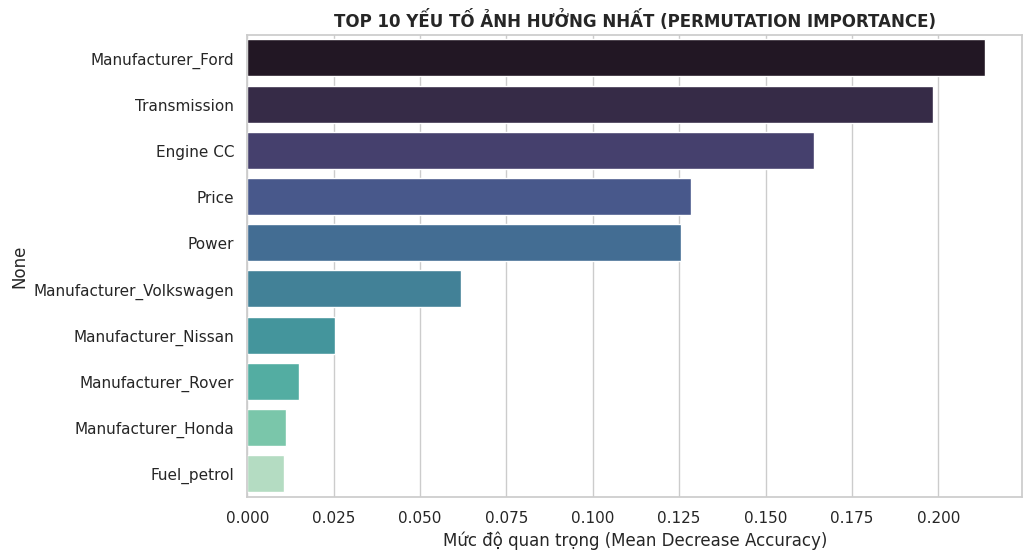

In [10]:
# --- #10: ĐỘ QUAN TRỌNG CỦA YẾU TỐ (PERMUTATION IMPORTANCE) ---

res = permutation_importance(best_rfr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(res.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("--> TOP 10 YẾU TỐ ẢNH HƯỞNG NHẤT:\n", perm_imp.head(10).to_string())

# Vẽ biểu đồ Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_imp.head(10).values, y=perm_imp.head(10).index, palette='mako')
plt.title('TOP 10 YẾU TỐ ẢNH HƯỞNG NHẤT (PERMUTATION IMPORTANCE)', fontweight='bold')
plt.xlabel('Mức độ quan trọng (Mean Decrease Accuracy)')
plt.show()

--> 🧠 Đang tính toán SHAP Values...


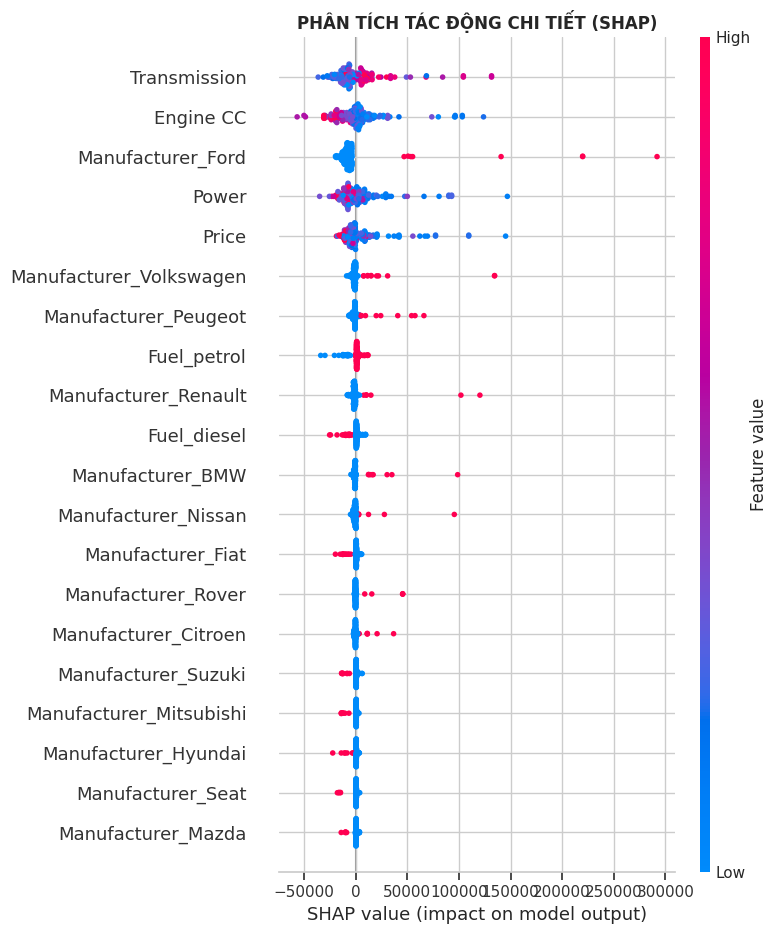

In [11]:
# --- #11: GIẢI MÃ CHIỀU HƯỚNG TÁC ĐỘNG (SHAP) ---
try:
    import shap
except ImportError:
    !pip install shap --quiet
    import shap

print("--> 🧠 Đang tính toán SHAP Values...")
explainer = shap.TreeExplainer(best_rfr)
X_sample = X_test.sample(n=min(200, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_sample)

plt.figure(figsize=(10, 6))
plt.title("PHÂN TÍCH TÁC ĐỘNG CHI TIẾT (SHAP)", fontsize=12, fontweight='bold')
shap.summary_plot(shap_values, X_sample, show=False)
plt.show()

**Nhận xét:**
- Chấm ĐỎ nằm bên PHẢI: Giá trị biến cao làm TĂNG khả năng khách hàng mua xe.
- Chấm ĐỎ nằm bên TRÁI: Giá trị biến cao làm GIẢM khả năng khách hàng mua xe.

**BƯỚC 6: LƯU TRỮ MÔ HÌNH**  
Mục đích: Đóng gói model để Deploy lên Web..

In [12]:
# --- CODE #12: LƯU TRỮ MÔ HÌNH ---
print("--> 💾 Đang lưu trữ mô hình...")

# Lưu Model
joblib.dump(best_rfr, 'car_purchase_model.joblib')

# Lưu danh sách cột (Để đảm bảo Input đầu vào khớp khi Deploy)
joblib.dump(X_train.columns, 'model_columns.joblib')

print("✅ ĐÃ LƯU THÀNH CÔNG!")
print("   1. car_purchase_model.joblib (Model dự đoán)")
print("   2. model_columns.joblib (Cấu trúc dữ liệu)")

--> 💾 Đang lưu trữ mô hình...
✅ ĐÃ LƯU THÀNH CÔNG!
   1. car_purchase_model.joblib (Model dự đoán)
   2. model_columns.joblib (Cấu trúc dữ liệu)
